<a href="https://colab.research.google.com/github/Sandesh02/FSM-INT-2022/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##importing reuired librarys

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import *

In [5]:
index_names = ['unit', 'cycles']
setting_names = ['OPsetting_1', 'OPsetting_2', 'OPsetting_3']
sensor_names = ['sensor {}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data


train = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In EDA we got to know that sensors 1,5,6,10,16,18,19 doesnt contribut to the RUL so we can drop those features while tranning the model.

In [6]:
def calculateRUL(df):
    
    #calculating max cycle for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = calculateRUL(train)
train[index_names+['RUL']]

,unit,cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
...,...,...,...
20626,100,196,4
20627,100,197,3
20628,100,198,2
20629,100,199,1


In [ ]:
train

,unit,cycles,OPsetting_1,OPsetting_2,OPsetting_3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


# implementing linear regression model

In [ ]:
drop_sensors = ['sensor 1','sensor 5','sensor 6','sensor 10','sensor 16','sensor 18','sensor 19']

drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit').last().reset_index().drop(drop_labels, axis=1)


defining function to check the predicted and true values 

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

tranning linear regression model

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test,'test')

train set RMSE:44.66819159545432, R2:0.5794486527796756
test set RMSE:31.952633027739118, R2:0.40877368076584075


**here we can see that our model is giving approx 45% root mean square error on train dataset and 32% error on train dataset.**

#  TRANNING RANDOM FOREST ALGORITHM

In [14]:
df1 = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_train_FD001.txt'), sep='\s+', header=None, names=col_names)
#df2 = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_train_FD002.txt'), sep='\s+', header=None, names=col_names)
#df3 = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_train_FD003.txt'), sep='\s+', header=None, names=col_names)
#df4 = pd.read_csv(('/content/drive/My Drive/Colab Notebooks/_train_FD004.txt'), sep='\s+', header=None, names=col_names)



In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#df = pd.concat([df1,df2,df3,df4])

In [18]:
df1

,unit,cycles,OPsetting_1,OPsetting_2,OPsetting_3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# **Data preprocessing**

---



In [19]:
df=calculateRUL(df1)

[Text(0, 0.5, 'unit'),
 Text(0, 1.5, 'cycles'),
 Text(0, 2.5, 'OPsetting_1'),
 Text(0, 3.5, 'OPsetting_2'),
 Text(0, 4.5, 'OPsetting_3'),
 Text(0, 5.5, 'sensor 1'),
 Text(0, 6.5, 'sensor 2'),
 Text(0, 7.5, 'sensor 3'),
 Text(0, 8.5, 'sensor 4'),
 Text(0, 9.5, 'sensor 5'),
 Text(0, 10.5, 'sensor 6'),
 Text(0, 11.5, 'sensor 7'),
 Text(0, 12.5, 'sensor 8'),
 Text(0, 13.5, 'sensor 9'),
 Text(0, 14.5, 'sensor 10'),
 Text(0, 15.5, 'sensor 11'),
 Text(0, 16.5, 'sensor 12'),
 Text(0, 17.5, 'sensor 13'),
 Text(0, 18.5, 'sensor 14'),
 Text(0, 19.5, 'sensor 15'),
 Text(0, 20.5, 'sensor 16'),
 Text(0, 21.5, 'sensor 17'),
 Text(0, 22.5, 'sensor 18'),
 Text(0, 23.5, 'sensor 19'),
 Text(0, 24.5, 'sensor 20'),
 Text(0, 25.5, 'sensor 21'),
 Text(0, 26.5, 'RUL')]

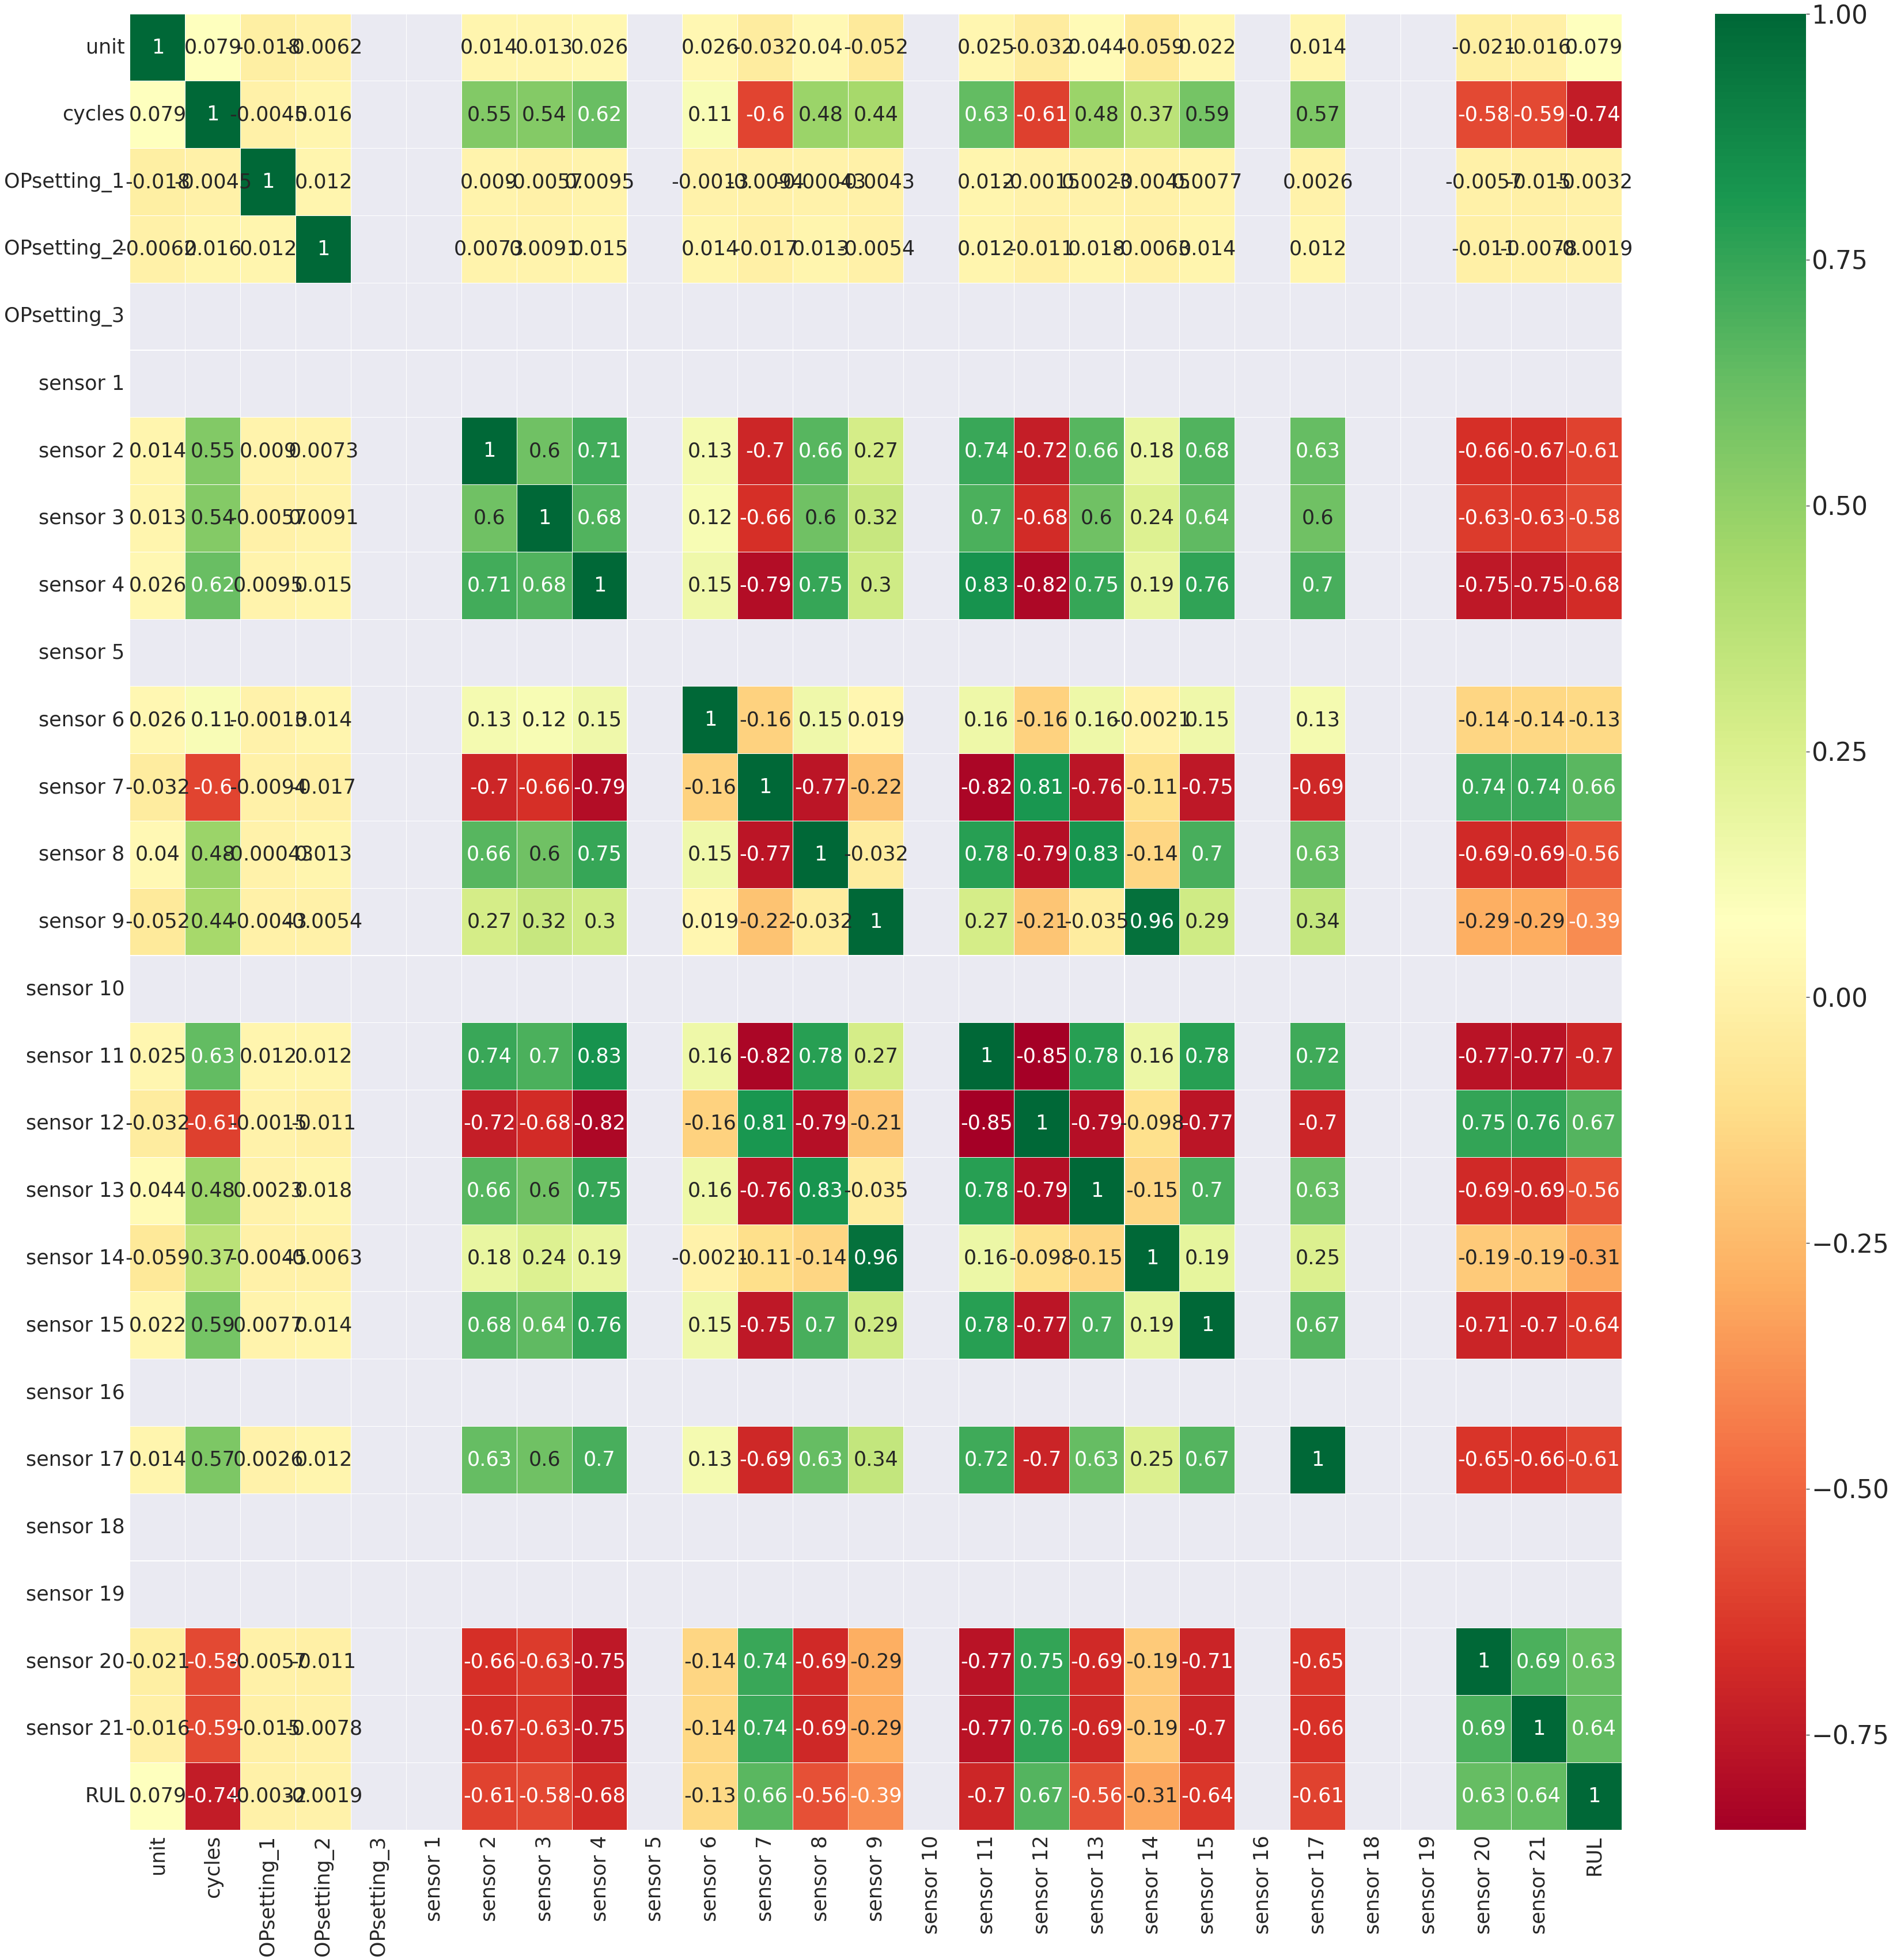

In [20]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(58,58))
#plt.savefig('Corrplot.png',bbox_inches='tight')
sns.set(font_scale=4,font="DejaVu Sans")

#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),cmap="RdYlGn", linewidths=0.1, annot=True, annot_kws={"size":35})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 35)
g.set_yticklabels(g.get_xmajorticklabels(), fontsize = 35)

In [21]:
delete_columns=[]

for col in df.columns:
    corr = df[col].corr(df['RUL'])
    #print(col,corr)
    if abs(corr)>0.5:
        pass
    else:    
        delete_columns.append(col)
        
delete_columns

['unit',
 'OPsetting_1',
 'OPsetting_2',
 'OPsetting_3',
 'sensor 1',
 'sensor 5',
 'sensor 6',
 'sensor 9',
 'sensor 10',
 'sensor 14',
 'sensor 16',
 'sensor 18',
 'sensor 19']

In [22]:
new_df = df.drop(columns=delete_columns)
new_df

,cycles,sensor 2,sensor 3,sensor 4,sensor 7,sensor 8,sensor 11,sensor 12,sensor 13,sensor 15,sensor 17,sensor 20,sensor 21,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,643.49,1597.98,1428.63,551.43,2388.19,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20627,197,643.54,1604.50,1433.58,550.86,2388.23,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20628,198,643.42,1602.46,1428.18,550.94,2388.24,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20629,199,643.23,1605.26,1426.53,550.68,2388.25,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


In [25]:
X = new_df.iloc[:, 0:13]
y = new_df.iloc[:, 13]

y


0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 20631, dtype: int64

In [26]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)

[0.34319685 0.03216293 0.02592721 0.11519278 0.06230116 0.02629719
 0.13384791 0.07174698 0.02404527 0.05075244 0.0334647  0.04275876
 0.03830582]


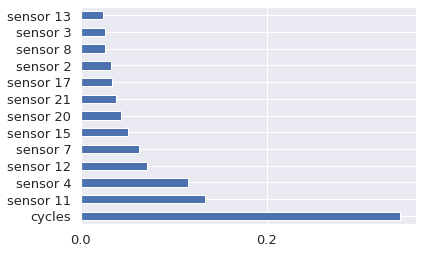

In [27]:
feat_importances = pd.Series(model.feature_importances_,index = X.columns)
feat_importances=feat_importances.sort_values( ascending=False)
feat_importances.nlargest(13).plot(kind='barh',fontsize =13)

In [28]:
feat_importances.keys()

Index(['cycles', 'sensor 11', 'sensor 4', 'sensor 12', 'sensor 7', 'sensor 15',
       'sensor 20', 'sensor 21', 'sensor 17', 'sensor 2', 'sensor 8',
       'sensor 3', 'sensor 13'],
      dtype='object')

In [29]:
feat_imp_df=new_df[['cycles', 'sensor 11', 'sensor 4', 'sensor 12', 'sensor 15',
       'sensor 20', 'sensor 7', 'sensor 21', 'sensor 2', 'sensor 17',
       'sensor 3', 'sensor 8', 'sensor 13']]

In [30]:
feat_imp_df

,cycles,sensor 11,sensor 4,sensor 12,sensor 15,sensor 20,sensor 7,sensor 21,sensor 2,sensor 17,sensor 3,sensor 8,sensor 13
0,1,47.47,1400.60,521.66,8.4195,39.06,554.36,23.4190,641.82,392,1589.70,2388.06,2388.02
1,2,47.49,1403.14,522.28,8.4318,39.00,553.75,23.4236,642.15,392,1591.82,2388.04,2388.07
2,3,47.27,1404.20,522.42,8.4178,38.95,554.26,23.3442,642.35,390,1587.99,2388.08,2388.03
3,4,47.13,1401.87,522.86,8.3682,38.88,554.45,23.3739,642.35,392,1582.79,2388.11,2388.08
4,5,47.28,1406.22,522.19,8.4294,38.90,554.00,23.4044,642.37,393,1582.85,2388.06,2388.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,48.07,1428.63,519.49,8.4956,38.49,551.43,22.9735,643.49,397,1597.98,2388.19,2388.26
20627,197,48.04,1433.58,519.68,8.5139,38.30,550.86,23.1594,643.54,395,1604.50,2388.23,2388.22
20628,198,48.09,1428.18,520.01,8.5646,38.44,550.94,22.9333,643.42,398,1602.46,2388.24,2388.24
20629,199,48.39,1426.53,519.67,8.5389,38.29,550.68,23.0640,643.23,395,1605.26,2388.25,2388.23


# **model tranning**

In [31]:
X = feat_imp_df.iloc[:, 0:-1]
y = new_df.iloc[:, 13]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train,y_train)

y_pred = regressor.predict(X_test)

from sklearn import metrics
print('RMSE on Test set:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

y_pred_train = regressor.predict(X_train)
print('RMSE on Training set:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

RMSE on Test set: 50.91960856196468
RMSE on Training set: 12.648534607156448


# **hyperparameter tunning**

---



**random grid**

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [33]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [35]:
rf_Model = RandomForestRegressor()

In [36]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [37]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [39]:
rf_RandomGrid.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 72}

In [40]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.714
Test Accuracy - : 0.558


In [45]:
y_pred = rf_RandomGrid.predict(X_test)

In [48]:
print('RMSE on Test set:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
y_pred_train = rf_RandomGrid.predict(X_train)
print('RMSE on Training set:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

RMSE on Test set: 52.28498468998953
RMSE on Training set: 35.2613545089441


**Grid Search for Hyperparameters Tuning**




In [49]:
RF = RandomForestRegressor( n_estimators= 400)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)
print('RMSE on Test set:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

y_pred_train = RF.predict(X_train)
print('RMSE on Training set:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

RMSE on Test set: 50.832045561131444
RMSE on Training set: 12.435528166993178


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
#rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [ ]:
#rf_Grid.fit(X_train, y_train)

In [53]:
n_estimators_list = [130,160,190]
criterion_list = ['gini']
max_depth_list = [35,55]
min_samples_split_list = [0.001, 0.005]
min_samples_leaf_list = [0.001, 0.005]
max_features_list = ['log2']

params_grid = {
    'n_estimators': n_estimators_list,
    'criterion': criterion_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list
}
params_grid

{'criterion': ['gini'],
 'max_depth': [35, 55],
 'max_features': ['log2'],
 'min_samples_leaf': [0.001, 0.005],
 'min_samples_split': [0.001, 0.005],
 'n_estimators': [130, 160, 190]}

In [56]:
def my_roc_auc_score(model, X, y): return metrics.roc_auc_score(y, model.predict(X))

model_rf = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                        param_grid=params_grid,
                        cv=3,
                        return_train_score=True,
                        verbose=4)

model_rf.fit(X,y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=130;, score=(train=0.739, test=0.016) total time=  18.9s
[CV 2/3] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=130;, score=(train=0.770, test=0.019) total time=  17.2s
[CV 3/3] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=130;, score=(train=0.778, test=0.016) total time=  17.0s
[CV 1/3] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=160;, score=(train=0.753, test=0.013) total time=  21.8s
[CV 2/3] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=160;, score=(train=0.782, test=0.016) total time=  21.5s
[CV 3/3] END criterion=gini, max_depth=35, max_features=log2, min_samples_leaf=0.001, min_sampl

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini'], 'max_depth': [35, 55],
                         'max_features': ['log2'],
                         'min_samples_leaf': [0.001, 0.005],
                         'min_samples_split': [0.001, 0.005],
                         'n_estimators': [130, 160, 190]},
             return_train_score=True, verbose=4)

In [57]:
model_rf.best_params_

{'criterion': 'gini',
 'max_depth': 55,
 'max_features': 'log2',
 'min_samples_leaf': 0.001,
 'min_samples_split': 0.001,
 'n_estimators': 190}

In [58]:
model_rf_fin = RandomForestClassifier(class_weight='balanced',
                                      criterion='gini',
                                      max_depth=55,
                                      max_features='log2',
                                      min_samples_leaf=0.001,
                                      min_samples_split=0.001,
                                      n_estimators=190)
model_rf_fin.fit(X,y)

RandomForestClassifier(class_weight='balanced', max_depth=55,
                       max_features='log2', min_samples_leaf=0.001,
                       min_samples_split=0.001, n_estimators=190)

In [67]:
print (f'Train Accuracy - : {model_rf_fin.score(X_train,y_train):}')
print (f'Test Accuracy - : {model_rf_fin.score(X_test,y_test):}')

Train Accuracy - : 0.6764420746485701
Test Accuracy - : 0.6966319360310153
